In [1]:
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
jpi.output_notebook()
from myastrotools.tools import SloangFilter,SloaniFilter,SloanrFilter,SloanzFilter, NIRC2HFilter, NIRC2JFilter
filters = [SloangFilter(),SloanrFilter(),SloaniFilter(),SloanzFilter(),NIRC2JFilter(),NIRC2HFilter()]
for f in filters:
    print(f.central_wavelength, f.wavelength_unit)

Loading BokehJS ...

4782.325 Angstrom
6260.406 Angstrom
7732.03 Angstrom
966.592 nm
1.246 um
1.621 um


# GJ 3021 b

## Planet signal

In [2]:
from myastrotools.reflectx_supplemental import GetPhotonsPerSec

directory = '../modeling/Modeling-Specific-Planets/'
directory += 'GJ3021b-Tstar5540-Rstar0.9-Teq311-sep0.553974645-rad11.94428742428012-mass3.37-mh1-co1.0-phase65'
spec = pd.read_csv(directory+'/cloud-free-spectrum-R500.csv', delim_whitespace=True)
wavelength = spec['wavelength [um]']
flux = spec['planet flux [ergs/cm2/s/cm]']
pdict, sdict, cdict = pickle.load(open(directory+'/cloud-free-model-inputs.pkl','rb'))

pl = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-target-list.csv')
ind = [i for i in range(len(pl)) if '3021' in pl['pl_name'].loc[i]]
gj = pl.loc[ind]


distance = gj['sy_dist'].item()*u.pc
planet_radius = pdict['radius']*pdict['radius_unit']
primary_mirror_diameter = 6.5*u.m
planet_signal = []
for filt in filters:
    planet_signal.append(GetPhotonsPerSec(wavelength, flux, filt, distance, 
                                          planet_radius, primary_mirror_diameter).value)
planet_signal = np.array(planet_signal)
planet_signal

array([4.78003139e+08, 3.90108769e+08, 1.65886892e+08, 2.51577062e+07,
       1.78194175e+06, 3.25817043e+05])

In [56]:
gj['Sep lod']

47    4.295537
Name: Sep lod, dtype: float64

## Star signal

In [19]:
star = pickle.load(open(directory+'/cloud-free-spectrum-full-output-R500.pkl','rb'))
wavelength = 1e4/star['star wavenumber']
flux = star['star flux']


# Photons/sec:
star_radius = sdict['radius']*u.Rsun
primary_mirror_diameter = 6.5*u.m
star_signal = []
for filt in filters:
    star_signal.append(GetPhotonsPerSec(wavelength, flux, filt, distance, star_radius, primary_mirror_diameter).value)
star_signal = np.array(star_signal)
star_signal, planet_signal

(array([8.64775950e+12, 1.04909720e+13, 1.11027148e+13, 1.56970603e+13,
        8.13513510e+12, 8.69706999e+12]),
 array([4.78003139e+08, 3.90108769e+08, 1.65886892e+08, 2.51577062e+07,
        1.78194175e+06, 3.25817043e+05]))

In [7]:
def GetFofLambdaNaught(wavelength,flux,filt):
    ''' For a specific filter object and spectrum, get the 
    flux at the central wavelength
    
    Args:
        wavelength (arr): wavelength array in microns
        flux (arr): flux array
        filt (filter object): filter
    
    Returns:
        flt: flux at the central wavelength
    '''
    from scipy.interpolate import interp1d
    f = interp1d(wavelength,flux)
    F0 = f(filt.central_wavelength*filt.wavelength_unit.to(u.um))
    return F0

def GetGuidestarMagForIasTable(wavelength, flux, filt, distance, star_radius, primary_mirror_diameter):
    import pysynphot as S
    star_flux_in_phot,star_flux_in_ergs, filt_w = GetPhotonsPerSec(wavelength, flux, filt, distance, star_radius, 
                                                       primary_mirror_diameter,
                                                       return_ergs_flux_times_filter=True)
    star_Flambda0 = GetFofLambdaNaught(filt_w, star_flux_in_ergs, filt)
    
    vega = S.Vega
    vega_Flam0 = vega.sample(filt.central_wavelength*filt.wavelength_unit.to(u.AA))
    vega_Flambda0 = vega_Flam0*(1/u.AA).to(1/u.cm)
    
    star_magnitude = -2.5 * np.log10(star_Flambda0/vega_Flambda0.value)
    available_mags = np.array(['0', '2.5', '5', '7', '9', '10', '11',
                        '11.5', '12', '12.5', '13','13.5', '14', '14.5', '15'])
    available_mags = np.array([float(m) for m in available_mags])
    idx = (np.abs(available_mags - star_magnitude)).argmin()
    guidestarmag = str(available_mags[idx]).replace('.0','')
    
    return guidestarmag, star_magnitude

star_gsm = []
star_mag = []
for filt in filters:
    gsm, mag = GetGuidestarMagForIasTable(wavelength, flux, filt, distance, star_radius, 
                                               primary_mirror_diameter)
    star_gsm.append(gsm)
    star_mag.append(mag)
star_gsm = np.array(star_gsm)
star_mag = np.array(star_mag)
star_gsm, star_mag

(array(['7', '7', '5', '5', '5', '5'], dtype='<U1'),
 array([7.00053684, 6.48360573, 5.87938381, 5.71728119, 5.44199456,
        5.07082854]))

In [34]:
pdict

{'tint': 150,
 'Teq': 311.45397881825255,
 'radius': 11.94428742428012,
 'radius_unit': Unit("jupiterRad"),
 'mass': 3.37,
 'mass_unit': Unit("jupiterMass"),
 'gravity': None,
 'gravity_unit': None,
 'semi_major': 0.553974645,
 'semi_major_unit': Unit("AU"),
 'mh': 1,
 'CtoO': 1.0,
 'phase': 65.380833781579,
 'num_tangle': 6,
 'num_gangle': 6,
 'noTiOVO': True,
 'planet_mh_str': '+000',
 'local_ck_path': '/Volumes/Oy/picaso/reference/kcoeff_2020/'}

In [39]:
def GetNoiseModelMap(guidestarmag, wfc):
    from astropy.io import fits
    IasMap = fits.getdata(f'/Users/loganpearce/Dropbox/astro_packages/myastrotools/myastrotools/GMagAO-X-noise/contrast_{guidestarmag}_{wfc}.fits')
    return IasMap

def GetIasFromTable(guidestarmag, wfc, sep, pa):
    ''' For a given guide star magnitude and wfc, look up the value of the atmospheric speckle
        contribution I_as (Males et al. 2021 eqn 6) at a given separation and position angle
        
    Args:
        guidestarmag (flt or str): Guide star magnitude. Must be: ['0', '2.5', '5', '7', '9', '10', '11',
                        '11.5', '12', '12.5', '13','13.5', '14', '14.5', '15']
        wfc (str): wavefront control set up.  Either linear predictive control "lp" or simple integrator "si"
        sep (flt): separation in lambda/D
        pa (flt): position angle in degrees
    
    Returns:
        flt: value of I_as at that location
    '''
    IasMap = GetNoiseModelMap(guidestarmag, wfc)
    center = [0.5*(IasMap.shape[0]-1),0.5*(IasMap.shape[1]-1)]
    dx = sep * np.cos(np.radians(pa + 90))
    dy = sep * np.sin(np.radians(pa + 90))
    if int(np.round(center[0]+dx, decimals=0)) < 0:
        return np.nan
    try:
        return IasMap[int(np.round(center[0]+dx, decimals=0)),int(np.round(center[1]+dy,decimals=0))]
    except IndexError:
        return np.nan
    
def GetIas(guidestarmag, wfc, sep, pa, wavelength):
    '''For a given guide star magnitude, wfc, and planet-star contrast, get the SNR
        in the speckle-limited regime (Eqn 10 of Males et al. 2021)
        at a given separation and position angle.
        
    Args:
        guidestarmag (flt or str): Guide star magnitude. Must be: ['0', '2.5', '5', '7', '9', '10', '11',
                        '11.5', '12', '12.5', '13','13.5', '14', '14.5', '15']
        wfc (str): wavefront control set up.  Either linear predictive control "lp" or simple integrator "si"
        sep (flt): separation in lambda/D
        pa (flt): position angle in degrees
        Cp (flt): planet-star contrast
        deltat (flt): observation time in sec
        wavelength (astropy units object):  central wavelength of filter band
        tau_as (flt): lifetime of atmospheric speckles in sec. Default = 0.02, ave tau_as for 24.5 m telescope
                from Males et al. 2021 Fig 10
    
    Returns:
        flt: value of I_as at that location
    '''
    wavelength = wavelength.to(u.um)
    # Look up Ias from table
    Ias = GetIasFromTable(guidestarmag, wfc, sep, pa)
    # Correct for differnce in wavelength between lookup table and filter wavelength:
    Ias = Ias * (((0.8*u.um/wavelength))**2).value
    if np.isnan(Ias):
        raise Exception('Sep/PA is outside noise map boundaries')
    else:
        return Ias
    
    

In [46]:
def Get_LOD(central_wavelength, D):
    ''' Return lambda/D in mas mas for a filter and primary diameter
    Args:
        central_wavelength (flt, astropy units object): wavelength of filter
        D (flt, astropy units object): primary diameter
    Returns:
        flt: lambda over D in mas
    '''
    central_wavelength = central_wavelength.to(u.um)
    D = D.to(u.m)
    lod = 0.206*central_wavelength.value/D.value
    lod = lod*u.arcsec.to(u.mas)
    return lod


[15.156291538461538,
 19.840671323076922,
 24.504587384615384,
 30.63353107692307,
 39.48861538461537,
 51.373230769230766]

In [58]:
sep_au = pdict['semi_major'] # au
sep_mas = (sep_au/distance.value)*u.arcsec.to(u.mas)
# LOD for 6.5m primary:
lods = [Get_LOD(f.central_wavelength*f.wavelength_unit, primary_mirror_diameter) for f in filters]
#lods = [Get_LOD(f.central_wavelength*f.wavelength_unit, 25.4*u.m) for f in filters]
sep_lods = [sep_mas/lod for lod in lods]
sep_lods

[2.0819669876360614,
 1.5904148667269546,
 1.2877139346519124,
 1.0300770929354504,
 0.7990885051482046,
 0.6142284253020744]

In [59]:
wfc = 'lp'
pa = 90 # deg

Ias = []
for i in range(len(filters)):
    wavelength = filters[i].central_wavelength*filters[i].wavelength_unit
    Ias.append(GetIas(star_gsm[i], wfc, sep_lods[i], pa, wavelength))
Ias = np.array(Ias)
Ias

array([2.70012344e-05, 1.57563926e-05, 1.89202267e-06, 1.21067341e-06,
       7.28580111e-07, 4.30474437e-07])

In [61]:
def GetPlanetSNR(Ip, Istar, Ic, Ias, Iqs, tau_as, tau_qs, deltat, 
                           RN = None, Isky = None, Idc = None, texp = None):
    signal = Ip * deltat
    photon_noise = Ic + Ias + Iqs
    atm_speckles = Istar * ( tau_as * (Ias**2 + 2*(Ic*Ias + Ias*Iqs)) )
    qs_speckles = Istar * ( tau_qs * (Iqs**2 + 2*Ic*Iqs) )
    sigma_sq_h = Istar * deltat * (photon_noise + atm_speckles + qs_speckles) + signal
    if RN is not None:
        skyanddetector = Isky*deltat + Idc*deltat + (RN * deltat/texp)**2
        noise = np.sqrt(sigma_sq_h + skyanddector)
    else:
        noise = np.sqrt(sigma_sq_h)
        
    return signal / noise

Ic = 1e-20
Iqs = 1e-20
tau_as = 0.02 # sec, from Fig 10 in Males+ 2021
tau_qs = 0.05 # value doesn't matter bc Iqs so small

ts = np.logspace(-2,5,1000) #seconds

all_snrs = []
for i in range(len(filters)):
    snrs = []
    for t in ts:
        snrs.append(GetPlanetSNR(planet_signal[i], star_signal[i], Ic, Ias[i], Iqs, tau_as, tau_qs, t, 
                           RN = None, Isky = None, Idc = None, texp = None))
    all_snrs.append(snrs)
        

# Make a function

In [7]:
def GetSNR(planet_wavelength, planet_flux, 
           star_wavelength, star_flux,
           primary_mirror_diameter, 
           planet_radius, star_radius, 
           distance, sep_au, wfc,
           filters, observationtime,
           Ic = 1e-20,
           Iqs = 1e-20,
           tau_as = 0.02, # sec, from Fig 10 in Males+ 2021
           tau_qs = 0.05,
           RN = None, Isky = None, Idc = None, texp = None
          ):
    
    from myastrotools.reflectx_supplemental import GetPhotonsPerSec
    
    ####### Signal:
    # Planet signal:
    planet_signal = []
    for filt in filters:
        planet_signal.append(GetPhotonsPerSec(planet_wavelength, planet_flux, filt, distance, 
                                              planet_radius, primary_mirror_diameter).value)
    planet_signal = np.array(planet_signal)
    
    # Star signal:
    star_signal = []
    for filt in filters:
        star_signal.append(GetPhotonsPerSec(star_wavelength, star_flux, filt, distance, 
                                            star_radius, primary_mirror_diameter).value)
    star_signal = np.array(star_signal)
    
    ####### Noise:
    ### Get Ias:
    # get guidestar magnitude:
    from myastrotools.reflectx_supplemental import GetGuidestarMagForIasTable, GetIas, Get_LOD
    star_gsm = []
    star_mag = []
    for filt in filters:
        gsm, mag = GetGuidestarMagForIasTable(star_wavelength, star_flux, filt, distance, star_radius, 
                                                   primary_mirror_diameter)
        star_gsm.append(gsm)
        star_mag.append(mag)
    star_gsm = np.array(star_gsm)
    star_mag = np.array(star_mag)
    # Get Ias from lookup table:
    sep_mas = (sep_au/distance.value)*u.arcsec.to(u.mas)
    # LOD:
    lods = [Get_LOD(f.central_wavelength*f.wavelength_unit, primary_mirror_diameter) for f in filters]
    sep_lods = [sep_mas/lod for lod in lods]

    pa = 90 # deg
    # Get Ias:
    Ias = []
    for i in range(len(filters)):
        wavelength = filters[i].central_wavelength*filters[i].wavelength_unit
        Ias.append(GetIas(star_gsm[i], wfc, sep_lods[i], pa, wavelength))
    Ias = np.array(Ias)
    
    ###### SNR:
    from myastrotools.reflectx_supplemental import ComputePlanetSNR

    if type(observationtime) == np.ndarray:
        # For an array of times:
        all_snrs = []
        for i in range(len(filters)):
            snrs = []
            for t in observationtime:
                snrs.append(ComputePlanetSNR(planet_signal[i], star_signal[i], 
                                             Ic, Ias[i], Iqs, tau_as, tau_qs, t, 
                                   RN = None, Isky = None, Idc = None, texp = None))
            all_snrs.append(snrs)
        return all_snrs
    else:
        # for a single time:
        snrs = []
        for i in range(len(filters)):
            snrs.append(ComputePlanetSNR(planet_signal[i], star_signal[i], Ic, Ias[i], Iqs, tau_as, tau_qs, 
                                observationtime, 
                                RN = RN, Isky = Isky, Idc = Idc, texp = texp))
        return snrs


# SNR for GMagAO-X

In [69]:
primary_mirror_diameter = 25.4*u.m
wfc = 'lp'

all_planet_snrs = {}

from myastrotools.tools import SloangFilter,SloaniFilter,SloanrFilter,SloanzFilter, NIRC2HFilter, NIRC2JFilter
filters = [SloangFilter(),SloanrFilter(),SloaniFilter(),SloanzFilter(),NIRC2JFilter(),NIRC2HFilter()]


from myastrotools.reflectx_supplemental import GetSNR

In [70]:
directory = '../modeling/Modeling-Specific-Planets/'
directory += 'GJ3021b-Tstar5540-Rstar0.9-Teq311-sep0.553974645-rad11.94428742428012-mass3.37-mh1-co1.0-phase65'
pdict, sdict, cdict = pickle.load(open(directory+'/cloud-free-model-inputs.pkl','rb'))
print(pdict['semi_major'])
print(sdict['Teff'])

spec = pd.read_csv(directory+'/cloud-free-spectrum-R500.csv', delim_whitespace=True)
planet_wavelength = spec['wavelength [um]']
planet_flux = spec['planet flux [ergs/cm2/s/cm]']
planet_radius = pdict['radius']*pdict['radius_unit']
sep_au = pdict['semi_major']

star = pickle.load(open(directory+'/cloud-free-spectrum-full-output-R500.pkl','rb'))
star_wavelength = 1e4/star['star wavenumber']
star_flux = star['star flux']
star_radius = sdict['radius']*u.Rsun

pl = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-target-list.csv')
ind = [i for i in range(len(pl)) if '3021' in pl['pl_name'].loc[i]]
gj = pl.loc[ind]

distance = gj['sy_dist'].item()*u.pc
print(distance)
# distance = pdict['distance']

observationtime = np.logspace(-2,5,1000)

all_snrs = GetSNR(planet_wavelength, planet_flux, 
           star_wavelength, star_flux,
           primary_mirror_diameter, 
           planet_radius, star_radius, 
           distance, sep_au, wfc,
           filters, observationtime,
           Ic = 1e-20,
           Iqs = 1e-20,
           tau_as = 0.02, # sec, from Fig 10 in Males+ 2021
           tau_qs = 0.05,
           RN = None, Isky = None, Idc = None, texp = None
          )

all_planet_snrs.update({gj['pl_name'].item():all_snrs})

0.553974645
5540.0
17.5559 pc


In [71]:
directory = '../modeling/Modeling-Specific-Planets/'
directory += 'HD40979b-Tstar6139-Rstar1.24-Teq320-sep0.89-rad11.97-mass3.83-mh1-co1.0-phase60'
pdict, sdict, cdict = pickle.load(open(directory+'/cloud-free-model-inputs.pkl','rb'))
print(pdict['semi_major'])
print(sdict['Teff'])

spec = pd.read_csv(directory+'/cloud-free-spectrum-R500.csv', delim_whitespace=True)
planet_wavelength = spec['wavelength [um]']
planet_flux = spec['planet flux [ergs/cm2/s/cm]']
planet_radius = pdict['radius']*pdict['radius_unit']
sep_au = pdict['semi_major']

star = pickle.load(open(directory+'/cloud-free-spectrum-full-output-R500.pkl','rb'))
star_wavelength = 1e4/star['star wavenumber']
star_flux = star['star flux']
star_radius = sdict['radius']*u.Rsun

pl = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-target-list.csv')
ind = [i for i in range(len(pl)) if '40979' in pl['pl_name'].loc[i]]
gj = pl.loc[ind]

distance = gj['sy_dist'].item()*u.pc
# distance = pdict['distance']
print(distance)

observationtime = np.logspace(-2,5,1000)

all_snrs = GetSNR(planet_wavelength, planet_flux, 
           star_wavelength, star_flux,
           primary_mirror_diameter, 
           planet_radius, star_radius, 
           distance, sep_au, wfc,
           filters, observationtime,
           Ic = 1e-20,
           Iqs = 1e-20,
           tau_as = 0.02, # sec, from Fig 10 in Males+ 2021
           tau_qs = 0.05,
           RN = None, Isky = None, Idc = None, texp = None
          )

all_planet_snrs.update({gj['pl_name'].item():all_snrs})

0.8859343274999999
6139.0
34.0883 pc


In [72]:
directory = '../modeling/Modeling-Specific-Planets/'
directory += 'HD183263b-Tstar5875-Rstar1.29-Teq232-sep1.62-rad11.96-mass3.704-mh1-co1.0-phase85'
pdict, sdict, cdict = pickle.load(open(directory+'/cloud-free-model-inputs.pkl','rb'))
print(pdict['semi_major'])
print(sdict['Teff'])

spec = pd.read_csv(directory+'/cloud-free-spectrum-R500.csv', delim_whitespace=True)
planet_wavelength = spec['wavelength [um]']
planet_flux = spec['planet flux [ergs/cm2/s/cm]']
planet_radius = pdict['radius']*pdict['radius_unit']
sep_au = pdict['semi_major']

star = pickle.load(open(directory+'/cloud-free-spectrum-full-output-R500.pkl','rb'))
star_wavelength = 1e4/star['star wavenumber']
star_flux = star['star flux']
star_radius = sdict['radius']*u.Rsun

pl = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-target-list.csv')
ind = [i for i in range(len(pl)) if '183263 b' in pl['pl_name'].loc[i]]
gj = pl.loc[ind]

distance = gj['sy_dist'].item()*u.pc
# distance = pdict['distance']
print(distance)

observationtime = np.logspace(-2,5,1000)

all_snrs = GetSNR(planet_wavelength, planet_flux, 
           star_wavelength, star_flux,
           primary_mirror_diameter, 
           planet_radius, star_radius, 
           distance, sep_au, wfc,
           filters, observationtime,
           Ic = 1e-20,
           Iqs = 1e-20,
           tau_as = 0.02, # sec, from Fig 10 in Males+ 2021
           tau_qs = 0.05,
           RN = None, Isky = None, Idc = None, texp = None
          )

all_planet_snrs.update({gj['pl_name'].item():all_snrs})

1.6160768218400001
5875.99
54.1955 pc


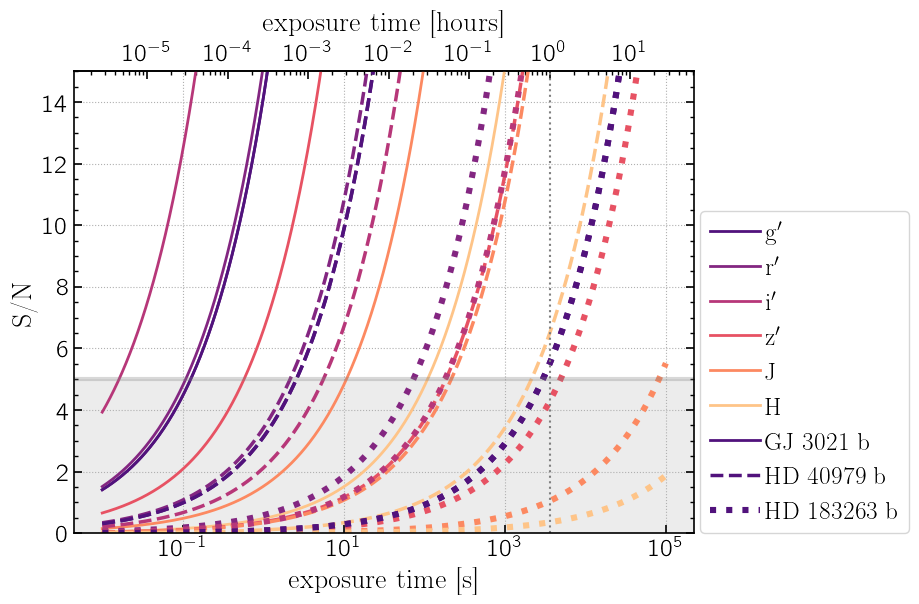

In [64]:
%matplotlib inline
import matplotlib
cmap = matplotlib.cm.get_cmap('magma')
cs = np.linspace(0,1,len(filters)+3)
colors = cmap(cs[2:])

linestyles = ['-','--',':']
lw = [2,2.5,4.4]
for j,key in enumerate(all_planet_snrs.keys()):
    all_snrs = all_planet_snrs[key]
    for i in range(len(filters)):
        if j == 0:
            plt.plot(observationtime,all_snrs[i], ls = linestyles[j], color=colors[i],
                     label=filters[i].label, lw=lw[j])
        else:
            plt.plot(observationtime,all_snrs[i], ls = linestyles[j], color=colors[i], lw=lw[j])
            
for j,key in enumerate(all_planet_snrs.keys()):  
    i = 0
    all_snrs = all_planet_snrs[key]
    plt.plot(observationtime,all_snrs[i], ls = linestyles[j], color=colors[i],
                     label=key, lw=lw[j])            

plt.axhline(y = 5, ls='-', color='grey', lw=3, alpha = 0.3)
plt.axhspan(0, 5, facecolor ='grey', alpha = 0.15)
plt.axvline(1*u.hr.to(u.s), color='grey',ls=':')

plt.gca().set_xscale('log')
plt.ylim(top=15, bottom=0)
plt.legend(fontsize=18, loc=(1.01,0))
plt.xlabel('exposure time [s]')
plt.ylabel('S/N')
plt.tick_params(
    axis='x',
    which='both',
    bottom=True,
    top=False,
    labelbottom=True)
def SecToHr(x):
    return x*u.s.to(u.hr)
def HrToSec(x):
    return x*u.hr.to(u.s)

secax = plt.gca().secondary_xaxis('top', functions=(SecToHr, HrToSec))
secax.set_xlabel('exposure time [hours]')
secax.xaxis.labelpad = 10

plt.grid(ls=':')

plt.savefig('../modeling/Modeling-Specific-Planets/snr-vs-time-for-3-planets-25.4m.png', 
            format='png', bbox_inches='tight')

In [57]:
pl = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-target-list.csv')
ind = [i for i in range(len(pl)) if '3021' in pl['pl_name'].loc[i]]
gj = pl.loc[ind]
#[print(c,gj[c].item()) for c in gj.columns]
orbits = pd.read_csv('../ExploringGmagAOXTargetList/GMagAO-X-RV-targets-with-orbital-params.csv')
ind = [i for i in range(len(orbits)) if '3021' in orbits['pl_name'].loc[i]]
gj = orbits.loc[ind]
[print(c,gj[c].item()) for c in gj.columns]

pl_orbsmax 0.49
pl_orbper 133.71
pl_orbincl nan
pl_orbeccen 0.511
pl_masse nan
pl_msinie 1071.04
st_mass 0.9
sy_dist 17.5559
Re 11.94428742428012
pl_orblper 290.7
pl_name GJ 3021 b
SpT Number 4.6
pl_mass_or_msini_e 1071.04
contrast_at_highest_contrast 0.1387922164117974
separation_at_highest_contrast 0.0052114383650436
phase_at_highest_contrast 30.00003397034173
separation_at_largest_separation 4.713343546624294
contrast_at_largest_separation 1.0684117034582369e-07
phase_at_largest_separation 65.380833781579
separation_at_average_separation 5.0319898369474725
contrast_at_average_separation 1.0684117034582369e-07
phase_at_average_separation 65.380833781579


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]